In [59]:
import bs4 as bs
import pickle
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

In [73]:
resp = requests.get("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
soup = bs.BeautifulSoup(resp.text)
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)
with open('sp500tickers.pickle','wb') as f:
    pickle.dump(tickers,f)
tickers
None
#ignore this was going to do a different approach earlier, left it here incase

In [74]:
sp500Data = pd.read_csv("S_P500_Rets.csv")
sentimentData = pd.read_csv("weekly_sentiment.csv")
sp500Data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Day,Weekly_Ret,2Weekly_Ret,LogWeekly_Ret,Log2Weekly_Ret,4Weekly_Ret,Log4_Weekly
0,07-01-05,1187.890015,1192.199951,1182.160034,1186.189941,1186.189941,1477900000,6,0.000000,0.000000,NaN,NaN,NaN,NaN
1,14-01-05,1177.449951,1185.209961,1177.449951,1184.520020,1184.520020,1335400000,6,-0.001408,0.000000,-0.001409,NaN,NaN,NaN
2,21-01-05,1175.410034,1179.449951,1167.819946,1167.869995,1167.869995,1643500000,6,-0.014056,-0.015444,-0.014156,-0.015565,NaN,NaN
3,28-01-05,1174.550049,1175.609985,1166.250000,1171.359985,1171.359985,1641800000,6,0.002988,-0.011110,0.002984,-0.011172,NaN,NaN
4,04-02-05,1189.890015,1203.469971,1189.670044,1203.030029,1203.030029,1648160000,6,0.027037,0.030106,0.026678,0.029662,0.014197,0.014097


In [75]:
sentimentData.head()
sentimentData["WeekID"] = pd.to_datetime(sentimentData['WeekID'], format='%Y/%m/%d')
#sentimentData1week = sentimentData
#sentimentData2week = sentimentData
# sentimentData["Date"] = sentimentData["WeekID"] + timedelta(days=2)
sentimentData["Date"] = sentimentData["WeekID"] - timedelta(days=1)
#sentimentData2week["Date"] = sentimentData2week["WeekID"] + timedelta(days=16)
sentimentData
#these commented out values are so we can run the regression on a couple a week or 2 in advance.

,WeekID,pos,neg,net_sent,Date
0,2005-01-08,0.094,0.024,0.01681,2005-01-07
1,2005-01-15,0.094,0.024,0.01681,2005-01-14
2,2005-01-22,0.094,0.024,0.01681,2005-01-21
3,2005-01-29,0.094,0.024,0.01681,2005-01-28
4,2005-02-05,0.094,0.024,0.01681,2005-02-04
...,...,...,...,...,...
516,2014-11-29,0.148,0.167,-0.07219,2014-11-28
517,2014-12-06,0.148,0.167,-0.07219,2014-12-05
518,2014-12-13,0.148,0.167,-0.07219,2014-12-12
519,2014-12-20,0.148,0.167,-0.07219,2014-12-19


In [76]:
sp500Data['Date'] = pd.to_datetime(sp500Data['Date'], format='%d-%m-%y')
sp500Data['Year'] = sp500Data['Date'].dt.year
sp500Data['Month'] = sp500Data['Date'].dt.month
sp500Data['Day'] = sp500Data['Date'].dt.day
sp500Data['Name'] = sp500Data['Date'].dt.weekday_name
sp500Data["Adj_Close"] = sp500Data["Adj Close"]
sp500MusicData = sp500Data[sp500Data["Name"]=="Friday"]
sp500MusicData.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Day,Weekly_Ret,2Weekly_Ret,LogWeekly_Ret,Log2Weekly_Ret,4Weekly_Ret,Log4_Weekly,Year,Month,Name,Adj_Close
0,2005-01-07,1187.890015,1192.199951,1182.160034,1186.189941,1186.189941,1477900000,7,0.000000,0.000000,NaN,NaN,NaN,NaN,2005,1,Friday,1186.189941
1,2005-01-14,1177.449951,1185.209961,1177.449951,1184.520020,1184.520020,1335400000,14,-0.001408,0.000000,-0.001409,NaN,NaN,NaN,2005,1,Friday,1184.520020
2,2005-01-21,1175.410034,1179.449951,1167.819946,1167.869995,1167.869995,1643500000,21,-0.014056,-0.015444,-0.014156,-0.015565,NaN,NaN,2005,1,Friday,1167.869995
3,2005-01-28,1174.550049,1175.609985,1166.250000,1171.359985,1171.359985,1641800000,28,0.002988,-0.011110,0.002984,-0.011172,NaN,NaN,2005,1,Friday,1171.359985
4,2005-02-04,1189.890015,1203.469971,1189.670044,1203.030029,1203.030029,1648160000,4,0.027037,0.030106,0.026678,0.029662,0.014197,0.014097,2005,2,Friday,1203.030029


In [96]:
#sentimentData("MatchingData", sp500MusicData.iloc[2, 0])
mergeData =pd.merge(sp500MusicData,sentimentData, on=["Date"], how="inner")
mergeData = mergeData.drop([0,1,2,3], axis=0)
mergeData = mergeData.rename(columns={"Log4_Weekly": "4_Week_Log_Return", "LogWeekly_Ret": "1_Week_Log_Return","net_sent":"Billboard_Sentiment"})
mergeData

,Date,Open,High,Low,Close,Adj Close,Volume,Day,Weekly_Ret,2Weekly_Ret,...,4Weekly_Ret,4_Week_Log_Return,Year,Month,Name,Adj_Close,WeekID,pos,neg,Billboard_Sentiment
4,2005-02-04,1189.890015,1203.469971,1189.670044,1203.030029,1203.030029,1648160000,4,0.027037,0.030106,...,0.014197,0.014097,2005,2,Friday,1203.030029,2005-02-05,0.094,0.024,0.01681
5,2005-02-11,1197.010010,1208.380005,1193.280029,1205.300049,1205.300049,1562300000,11,0.001887,0.028975,...,0.017543,0.017391,2005,2,Friday,1205.300049,2005-02-12,0.094,0.024,0.01681
6,2005-02-18,1200.750000,1202.920044,1197.349976,1201.589966,1201.589966,1551200000,18,-0.003078,-0.001197,...,0.028873,0.028464,2005,2,Friday,1201.589966,2005-02-19,0.094,0.024,0.01681
7,2005-02-25,1200.199951,1212.150024,1199.609985,1211.369995,1211.369995,1523680000,25,0.008139,0.005036,...,0.034157,0.033586,2005,2,Friday,1211.369995,2005-02-26,0.094,0.024,0.01681
8,2005-03-04,1210.469971,1224.760010,1210.469971,1222.119995,1222.119995,1636820000,4,0.008874,0.017086,...,0.015868,0.015744,2005,3,Friday,1222.119995,2005-03-05,0.094,0.024,0.01681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,2014-11-28,2074.780029,2075.760010,2065.060059,2067.560059,2067.560059,2504640000,28,0.001968,0.013599,...,0.024534,0.024237,2014,11,Friday,2067.560059,2014-11-29,0.148,0.167,-0.07219
501,2014-12-05,2072.780029,2079.469971,2070.810059,2075.370117,2075.370117,3419620000,5,0.003777,0.005752,...,0.021384,0.021158,2014,12,Friday,2075.370117,2014-12-06,0.148,0.167,-0.07219
502,2014-12-12,2030.359985,2032.250000,2002.329956,2002.329956,2002.329956,4157650000,12,-0.035194,-0.031549,...,-0.018379,-0.018550,2014,12,Friday,2002.329956,2014-12-13,0.148,0.167,-0.07219
503,2014-12-19,2061.040039,2077.850098,2061.030029,2070.649902,2070.649902,6465530000,19,0.034120,-0.002274,...,0.003465,0.003459,2014,12,Friday,2070.649902,2014-12-20,0.148,0.167,-0.07219


In [98]:
#sp500MusicData.to_csv(index=False, path_or_buf = 's&p500weekly.csv')

In [100]:
mergeData.Billboard_Sentiment.describe()

count    501.000000
mean      -0.000593
std        0.125811
min       -0.468190
25%       -0.068190
50%        0.000810
75%        0.066810
max        0.531810
Name: Billboard_Sentiment, dtype: float64

In [97]:
Y = '4_Week_Log_Return'
X = mergeData.loc[:,["Date", Y, "Billboard_Sentiment"]]
X_with_ones=sm.add_constant(X.drop(['Date',Y], axis=1))
fullmod = sm.OLS(endog=mergeData[Y], exog=X_with_ones.astype(float)).fit()
fullmod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      4_Week_Log_Return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.156
Date:                Tue, 08 Oct 2019   Prob (F-statistic):              0.143
Time:                        20:53:33   Log-Likelihood:                 792.11
No. Observations:                 501   AIC:                            -1580.
Df Residuals:                     499   BIC:                            -1572.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0045      0.002      2.009      0.045    9.85e-05       0.009
Billboard_Sentiment     0.0260      0.018      1.468      0.143      -0.009       0.061
==============================================================================
Omnibus:                      253.592   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2803.267
Skew:                          -1.933   Prob(JB):                         0.00
Kurtosis:                      13.924   Cond. No.                         7.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

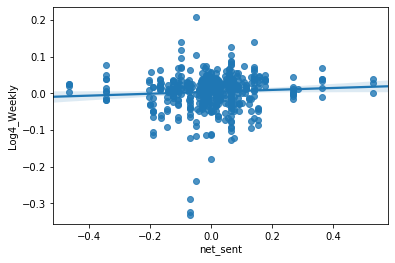

In [79]:
sns.regplot(y=mergeData[Y], x=mergeData["net_sent"])

In [81]:
bd_robust = sm.RLM.from_formula(formula = "Log4_Weekly ~ net_sent", data=mergeData).fit()
bd_robust.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:            Log4_Weekly   No. Observations:                  501
Model:                            RLM   Df Residuals:                      499
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 08 Oct 2019                                         
Time:                        20:48:36                                         
No. Iterations:                    16                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0085      0.002      5.103      0.000       0.005       0.012
net_sent       0.0196      0.013      1.474      0.141      -0.006       0.046
==============================================================================

If the model instance has been used for another fit with different fit
parameters, then the fit options might not be the correct ones anymore .
"""

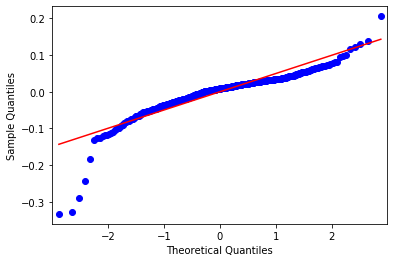

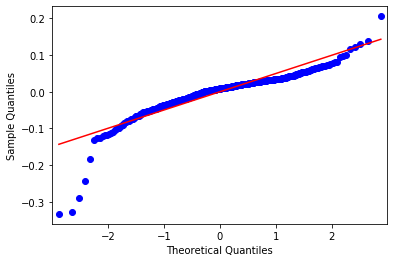

In [85]:
qqplot(fullmod.resid, line='s')